In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [106]:
# read Seattle and Boston Calenadar
seattle_cal = pd.read_csv('seattle/calendar.csv', index_col='date', parse_dates=['date'])
boston_cal = pd.read_csv('boston/calendar.csv', index_col='date', parse_dates=['date'])

In [107]:
# available is True
seattle_available = seattle_cal[seattle_cal['available'] == 't']
boston_available = boston_cal[boston_cal['available'] == 't']

In [108]:
# price type convert to float

# seattle
seattle_available.loc[:, 'price'] = seattle_available['price'].apply(lambda x: x.replace('$', '').replace(',', '')).values
seattle_available.loc[:, 'price'] = seattle_available['price'].astype(np.float)

# boston
boston_available.loc[:, 'price'] = boston_available['price'].apply(lambda x: x.replace('$', '').replace(',', '')).values
boston_available.loc[:, 'price'] = boston_available['price'].astype(np.float)

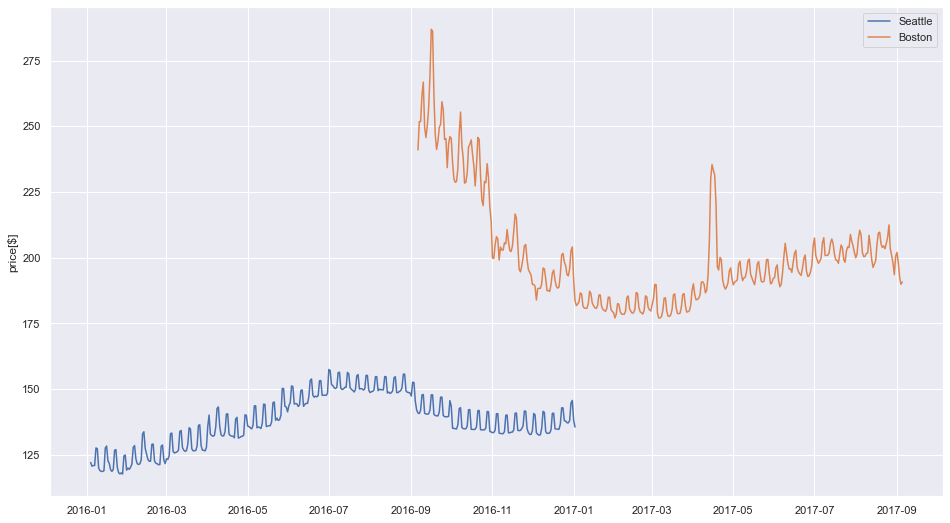

In [114]:
plt.figure(figsize=(16, 9))
plt.plot(seattle_available.resample('D')['price'].mean(), label='Seattle')
plt.plot(boston_available.resample('D')['price'].mean(), label='Boston')
plt.legend()
plt.ylabel('price[$]')
plt.show()

# ボストンマラソンのときに価格が上がっている

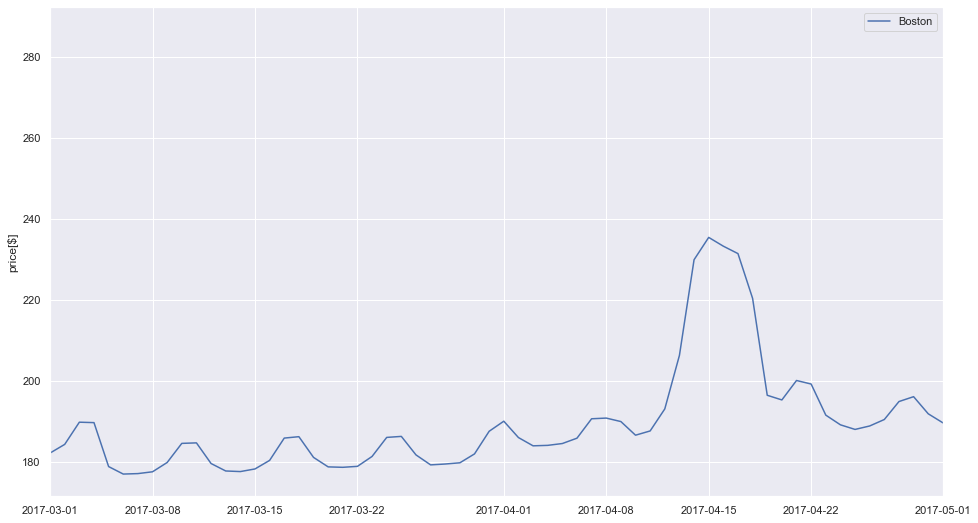

In [118]:
plt.figure(figsize=(16, 9))
plt.plot(boston_available.resample('D')['price'].mean(), label='Boston')
plt.xlim('2017-03-01', '2017-05-01')
plt.legend()
plt.ylabel('price[$]')
plt.show()

In [125]:
boston_is_av = boston_cal.groupby(['available', pd.Grouper(freq=('D'))]).nunique()

In [130]:
boston_is_av = boston_is_av.reset_index()

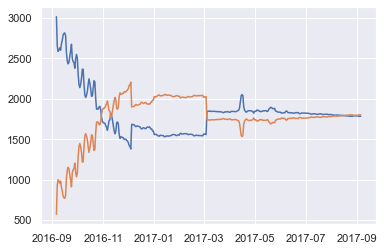

In [138]:
plt.plot(boston_is_av[boston_is_av['available'] == 'f'].set_index('date')['listing_id'])
plt.plot(boston_is_av[boston_is_av['available'] == 't'].set_index('date')['listing_id'])

In [140]:
boston_is_av[boston_is_av['available'] == 't'].set_index('date')['listing_id'].sum()

642957

In [141]:
boston_is_av[boston_is_av['available'] == 'f'].set_index('date')['listing_id'].sum()

665568

In [143]:
boston_listing = pd.read_csv('./seattle/listings.csv')

In [144]:
boston_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [145]:
boston_listing['id'].nunique()

3818

In [148]:
boston_cal['listing_id'].nunique()

3585

In [150]:
for col in boston_listing.columns:
    print(col)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_re